<a href="https://colab.research.google.com/github/JackyPro/DL_imageclassification/blob/main/DL_Vgg16_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 經典神經網路學習遷移式學習

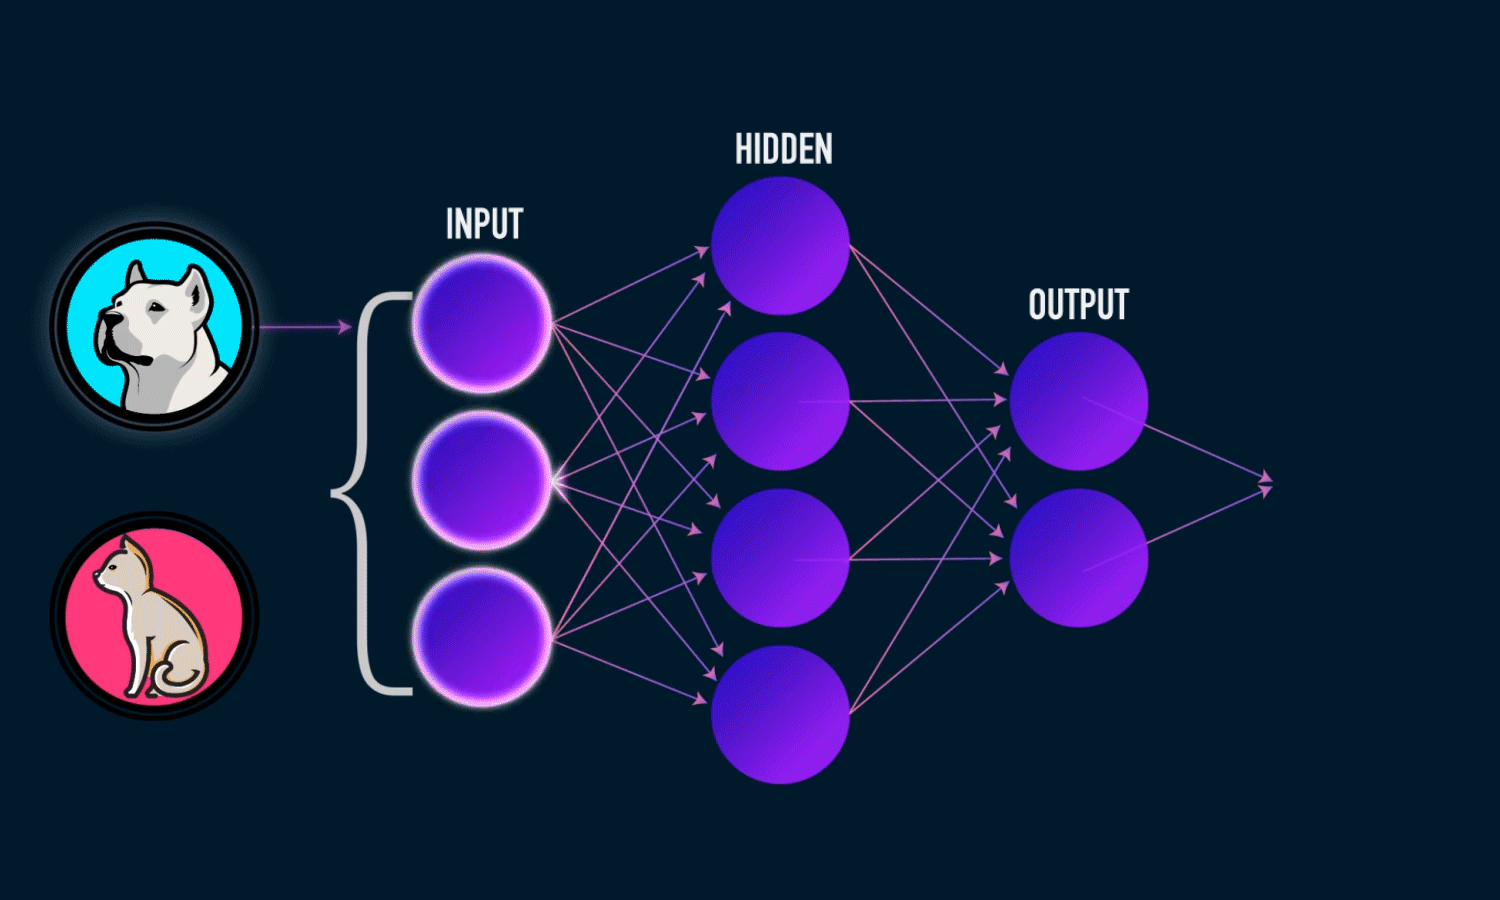

```
任務：
>> 使用預先訓練的 VGG16 卷積網絡來訓練新模型 - 圖像分類 
  範例中將使用已經訓練好的ImageNe數據集(140萬個標記的圖像 / 1000個不同的類別)的神經網路，  
  訓練新的數據集(25,000張貓和狗的圖像 / 每個類別12,500個 / 大小543MB（壓縮）

  解壓縮後
    - 創建一個包含三個子集的 - 新數據集(訓練集/驗證集/測試集)
  
    - 一組
        - 每組 每個類的 1000個樣本 - 訓練集
        - 每組 每個類的  500個樣本 - 驗證集
        - 每組 每個類的  500個樣本 - 測試集

        - 包括不同種類的　貓　和　狗
目標：
>> 期望在貓與狗分類問題上，能表現非常好

```


```
>> 下載數據集 (貓與狗的圖片集)

        >> https://www.kaggle.com/c/dogs-vs-cats/data
        
    >> dogs-vs-cats.zip
        >> 900.6 MB.Zip
            >> sampleSubmission
            >> train.zip
            >> test1.zip

>> Dogs vs. Cats images
    >> Dogs vs. Cats
        >> Data (812 MB)
        >> sampleSubmission 86.8 KB (88,903 位元組)
            >> 12.5K rows X 2 colummns 
            
        >> test1.zip  15,000 個檔案  
        >> train.zip  25,000 個檔案  
- 創建一個包含三個子集的 - 新數據集
                    - 一組
                    - 每組 每個類的 1000個樣本 - 訓練集
                    - 每組 每個類的  500個樣本 - 驗證集
                    - 每組 每個類的  500個樣本 - 測試集  
```





# Kaggle下載資料集

In [39]:
cd ../root/.kaggle

/root


In [ ]:
from google.colab import files
uploaded = files.upload()

In [17]:
! pip install -q kaggle

In [27]:
cd ../root/.kaggle/

/root/.kaggle


In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [30]:
!mkdir /content/input

In [31]:
!mkdir /content/input/dogs-vs-cats/

In [33]:
!cp sampleSubmission.csv test1.zip train.zip -d "/content/input/dogs-vs-cats"

In [40]:
cd /content

/content


# 連google雲端

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11031588870368444258
]


In [ ]:
import platform
import tensorflow
import tensorflow.keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(tensorflow.keras.__version__))

In [ ]:
!python -V
platform.python_version()

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 1.資料預處理



## a.載入資料

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/input/dogs-vs-cats/test1.zip
/content/input/dogs-vs-cats/sampleSubmission.csv
/content/input/dogs-vs-cats/train.zip


In [ ]:
import zipfile
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt

# 繪製線圖 (可將訓練時所傳回的損失值或準確率等歷史記錄繪製成線圖)
# history: 內含一或多筆要繪資料的字典, 例如：{'loss': [4,2,1,…], 'acc': [2,3,5,…]}
# keys: 以 tuple 或串列指定 history 中要繪製的 key 值, 例如：('loss', 'acc')
# title: 以字串指定圖表的標題文字
# xyLabel: 以 tuple 或串列指定 x, y 軸的說明文字, 例如：('epoch', 'Accuracy')
# ylim: 以 tuple 或串列指定 y 軸的最小值及最大值, 例如 (1, 3), 超出範圍的值會被忽略
# size: 以 tuple 指定圖的尺寸, 預設為 (6, 4) (即寬 6 高 4 英吋)
def plot(history_dict, keys, title=None, xyLabel=[], ylim=(), size=()):
    lineType = ('-', '--', '.', ':')    # 線條的樣式, 畫多條線時會依序採用
    if len(ylim)==2: plt.ylim(*ylim)    # 設定 y 軸最小值及最大值
    if len(size)==2: plt.gcf().set_size_inches(*size)  # size預設為 (6,4)
    epochs = range(1, len(history_dict[keys[0]])+1)  # 計算有幾週期的資料
    for i in range(len(keys)):   # 走訪每一個 key (例如 'loss' 或 'acc' 等)
        plt.plot(epochs, history_dict[keys[i]], lineType[i])  # 畫出線條
    if title:   # 是否顯示標題欄
        plt.title(title)
    if len(xyLabel)==2:  # 是否顯示 x, y 軸的說明文字
        plt.xlabel(xyLabel[0])
        plt.ylabel(xyLabel[1])
    plt.legend(keys, loc='best') # 顯示圖例 (會以 key 為每條線的說明)
    plt.show()  # 顯示出畫好的圖

#繪製多個影像資料及其對應的標籤值
#參數：
#  imgs、labels 為影像資料及標籤值
#  grid 為 (水平, 垂直) 個子圖表, 預設為水平 1 排中有 10 個子圖表
#  size 為圖表的 (寬, 高), 預設為 (20英吋, 2英吋)
def plot_img(imgs, labels=[], grid=(1, 20), size=(30, 2)):
    n = len(imgs)                     #←計算樣本數
    plt.gcf().set_size_inches(size)   #←指定圖表的寬度,高度 (英吋=2.54公分)
    for i in range(n):                #←依樣本數走訪
        ax = plt.subplot(grid[0], grid[1], i+1)   #←取得對應位置的子圖表 (共有 (1x樣本數) 個子圖表)
        ax.imshow(imgs[i])            #←顯示樣本 (影像) 內容
        if len(labels):
            ax.set_title(f'Label={labels[i]}')    #←以對應的標籤值做為子圖表的標題
        ax.set_xticks([]); ax.set_yticks([]) #←設定 X, Y 軸不顯示刻度
    plt.show()      #←實際顯示圖片

解壓縮檔案

In [ ]:
def extract_files(source_path, target_path):
    zip_ref = zipfile.ZipFile(source_path,'r')
    zip_ref.extractall(target_path)
    zip_ref.close()

In [ ]:
extract_files('/content/input/dogs-vs-cats/test1.zip','/content/working/')
extract_files('/content/input/dogs-vs-cats/train.zip','/content/working/')

資料夾路徑  
資料筆數


Populating the interactive namespace from numpy and matplotlib
cat.8473.jpg
(481, 500, 3)


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


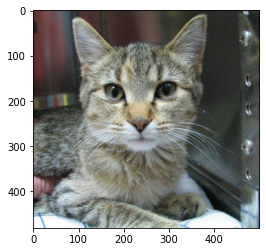

In [ ]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filenames = os.listdir(r"/content/working/train/")
sample = random.choice(filenames)
print(sample)

img=mpimg.imread('/content/working/train/' + sample)

#print(type(img))
print(img.shape)

imgplot = plt.imshow(img)
plt.show()

### 建立檔案路徑

In [ ]:
import os, shutil

# 專案 - 根目錄路徑
ROOT_DIR = os.getcwd()
# coco 圖像資料 與標註資料 - 的目錄
DATA_PATH = os.path.join(ROOT_DIR, "working")

# 原始數據集 - 的路徑
original_dataset_dir = os.path.join(DATA_PATH, "train")

# 存儲小數據集 - 的目錄
base_dir = os.path.join(DATA_PATH, "cats_and_dogs_small")
if not os.path.exists(base_dir): 
    os.mkdir(base_dir)

# 訓練資料 - 的目錄
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): 
    os.mkdir(train_dir)

# 驗證資料 - 的目錄
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir): 
    os.mkdir(validation_dir)

# 測試資料 - 的目錄
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)    

# 貓的圖片的訓練 - 資料目錄
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# 狗的圖片的訓練 - 資料目錄
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# 貓的圖片的驗證 - 資料目錄
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# 狗的圖片的驗證 - 資料目錄
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# 貓的圖片的測試 - 資料目錄
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# 狗的圖片的測試 - 資料目錄
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

In [ ]:
print(DATA_PATH)
print(original_dataset_dir)
print(base_dir)
print(train_dir)
print(validation_dir)
print(test_dir)
print(train_cats_dir)
print(train_dogs_dir)
print(validation_cats_dir)
print(validation_dogs_dir)
print(test_cats_dir)
print(test_dogs_dir)

/content/working
/content/working/train
/content/working/cats_and_dogs_small
/content/working/cats_and_dogs_small/train
/content/working/cats_and_dogs_small/validation
/content/working/cats_and_dogs_small/test
/content/working/cats_and_dogs_small/train/cats
/content/working/cats_and_dogs_small/train/dogs
/content/working/cats_and_dogs_small/validation/cats
/content/working/cats_and_dogs_small/validation/dogs
/content/working/cats_and_dogs_small/test/cats
/content/working/cats_and_dogs_small/test/dogs


### 切割資料
```

>> 計算每次訓練
    >> 分割中的圖片數量（訓練/驗證/測試）：
        >> training split (train/validation/test):

```

In [ ]:
# 複製 - 前 1000個貓的圖片 - 到 - train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy first 1000 cat images to train_cats_dir complete!')

# 複製 - 下 500個貓的圖片 - 到 - validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy next 500 cat images to validation_cats_dir complete!')

# 複製 - 下 500個貓的圖片 - 到 test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy next 500 cat images to test_cats_dir complete!')

# 複製 - 前 1000個狗 的圖片 到 - train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy first 1000 dog images to train_dogs_dir complete!')


# 複製 - 下 500個狗 的圖片 到 - validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy next 500 dog images to validation_dogs_dir complete!')

# Copy 複製 下 - 500個狗的圖片 到  - test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)
    
print('Copy next 500 dog images to test_dogs_dir complete!')

Copy next 500 cat images to validation_cats_dir complete!
Copy next 500 cat images to test_cats_dir complete!
Copy first 1000 dog images to train_dogs_dir complete!
Copy next 500 dog images to validation_dogs_dir complete!
Copy next 500 dog images to test_dogs_dir complete!


In [ ]:
print('total training  cat images:', len(os.listdir(train_cats_dir)))
print('total training  dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test    cat images:', len(os.listdir(test_cats_dir)))
print('total test    dog images:', len(os.listdir(test_dogs_dir)))

total training  cat images: 1000
total training  dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test    cat images: 500
total test    dog images: 500


# 2.特徵提取

```

>> 特徵提取 (Feature Extraction)

```

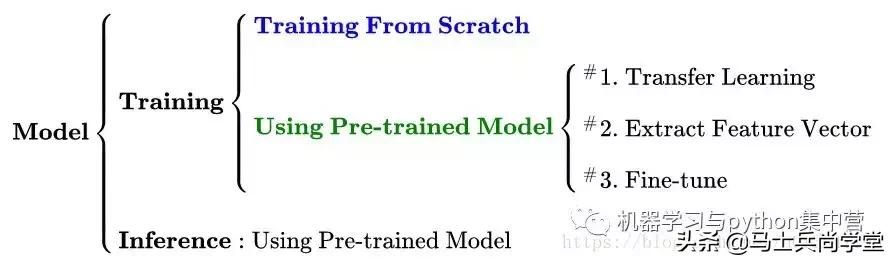

移花接木  
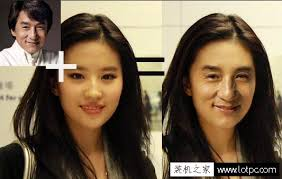

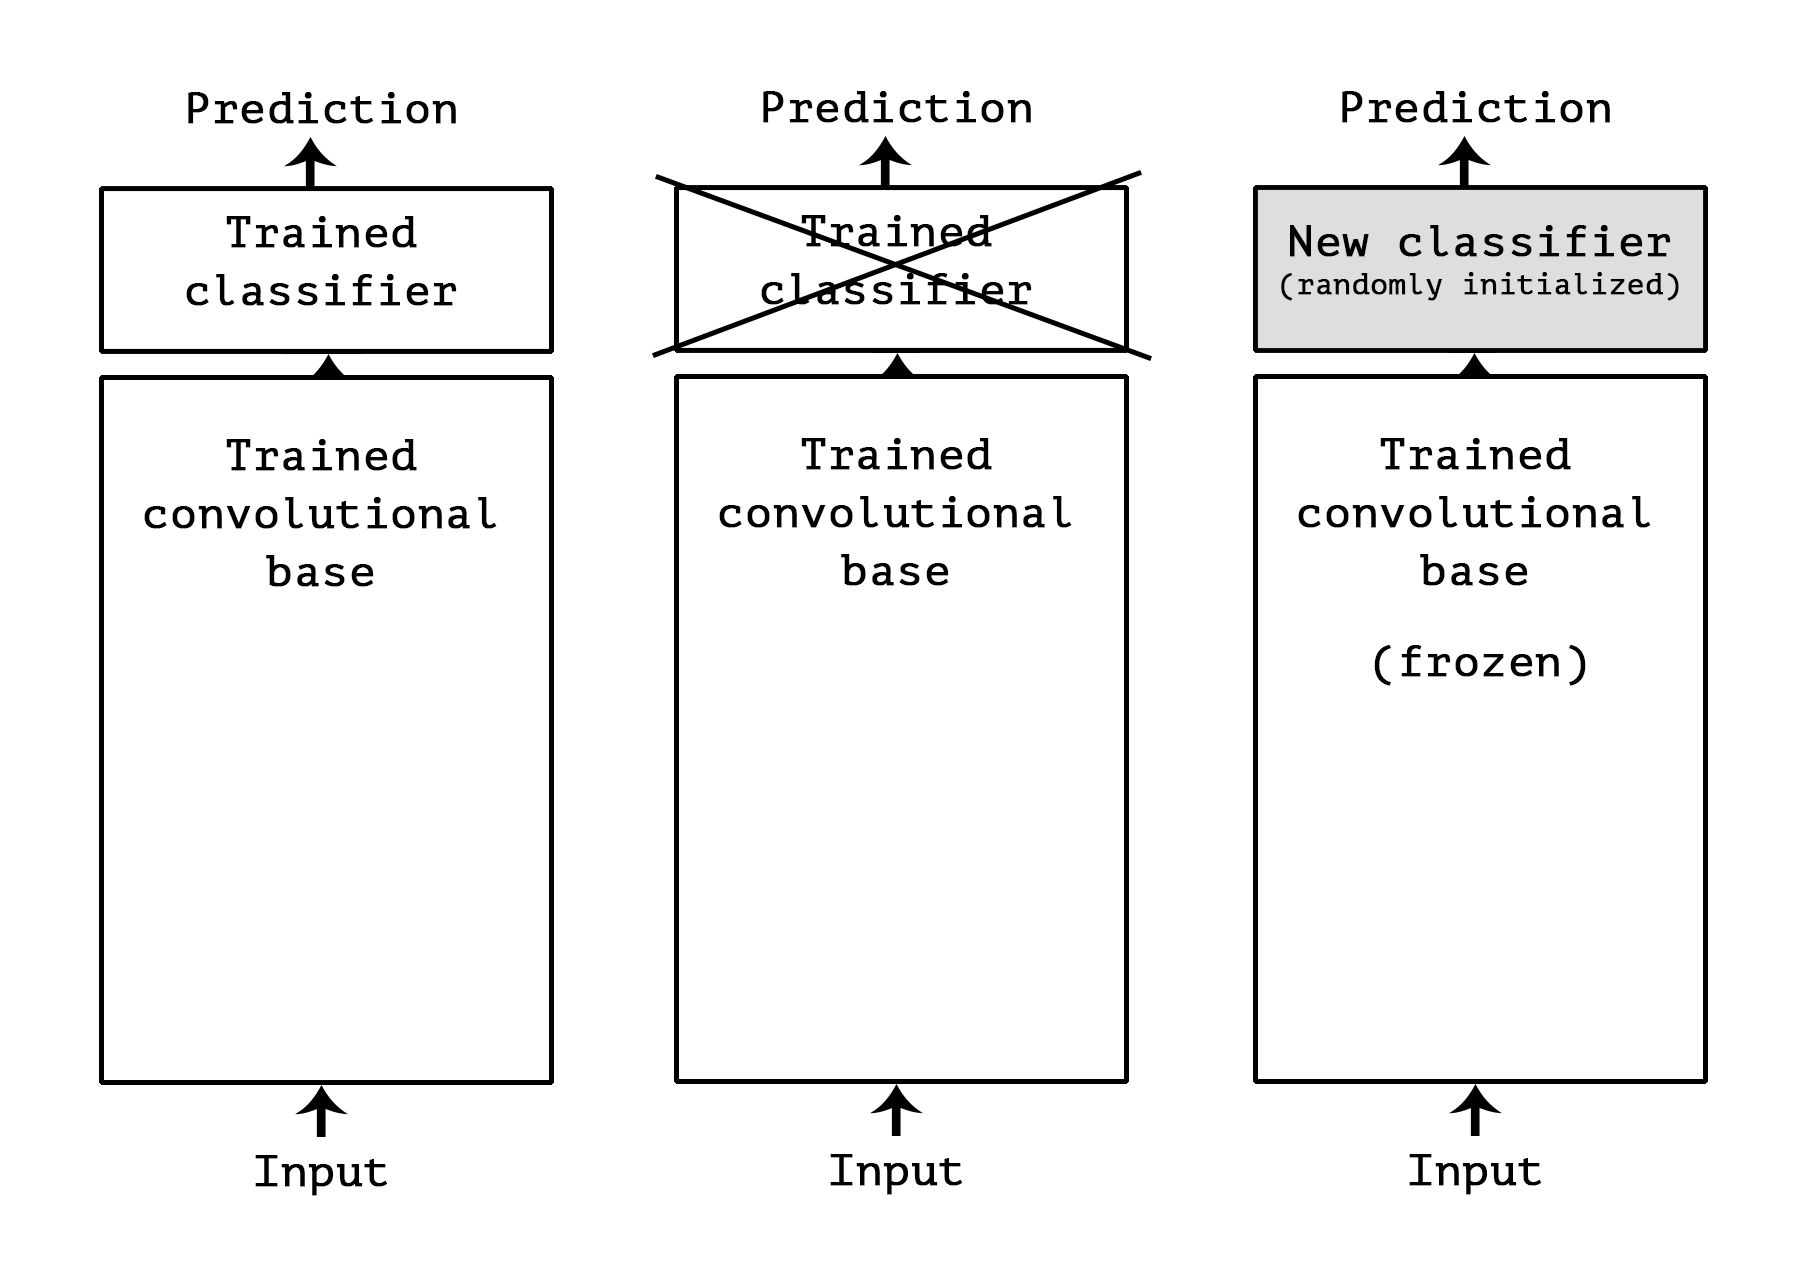

```

>> 特徵提取 - Fature Etraction

    >> 特徵提取
        - 包括了使用　預訓練好的網絡模型　來從　新樣本中提取特徵
        - 這些特徵通過一個 - 新 New - 的分類器 － 從頭開始訓練

    >> 用於　圖像分類的　卷積網絡(Convnets)架構
        -  包括了兩大部分：
            - 以一系列卷積　和　池化層開始
                - 並且以　密集連接(Densely-Connected)的分類器結束
                
            - 第一部分稱為模型的  - 卷積基底 - 
                - 卷積網絡裡 - 特徵提取 - 
                - 簡單地
                    - 包括先前訓練過的網絡的 - 卷積基底 -，
                    - 通過它重新餵入新的數據
                        - 根據- 卷積基底 -的輸出之後再
                        - 接續　訓練一個　新的　分類器

    >> 為什麼只重用 - 卷積基底 - 
        - 以重用　密集連接　(Densely-Connected)的分類器嗎 -  一般來說，應該避免
        
        - 原因是簡單地說
            -- 卷積基底 - 學習的特徵 可能是更通用的 - 因此更可重複使用
            - 一個卷積網絡的特徵圖 Feature Maps)
                - 是一個通用概念對應到圖片的映射
        - 另一方面
            - 分類器學習的特徵
                - 特定於模型被訓練的類別的集合 
                    -將僅包含關於整個圖片中該類或該類的存在機率的訊息

        - 密集連接 Densely-Connected 的層中
            - 發現的表示 (Representation)
                - 不再包含有關 - 空間/位置 - 位於輸入圖像中的任何信息
                    - 這些層己經擺脫了空間的概念
                    - 對於物件位置重要且敏感的問題
                    - 密集連接層的功能將
                        - 無法重覆利用的

    >> 範例中
        - ImageNet 類集合 包含多個 Dog 和 Cat 類
            - 所以重用
                - 包含在原始模型密集連接層中的信息很有可能是有益的
            - 但是，為了覆蓋更多的一般情況，將不會選擇使用原始模型密集連接層
                - 因為新的問題的類別集與原始模型的類別集並沒有重疊
                
      - ImageNet上訓練的 VGG16網絡
        -  - 卷積基底 - 
            - 來應用在 貓 和 狗 圖像中 - 提取特徵
                - 然後 在這些特徵之上
                - 訓練一個貓與狗分類器
                
        - Keras / VGG16 模型 己經預先　包裝在一起
        
        > keras.applications 模組
            - 以下是可用作 keras.applications 一部分的圖像分類預訓練的模型列表
                - 均在ImageNet數據集上預先訓練過了
            
            
            - from keras.applications import VGG16
              conv_base = VGG16(weights='imagenet',
                    include_top=False,         # Keras - 只需要卷積基底的 權重模型 資訊
                    input_shape=(150, 150, 3)) # 宣告  - 要處理的圖像 大小與顏色 通道數
                
                
            - Xception
            - InceptionV3
            - ResNet50
            - VGG16
            - VGG19
            - MobileNet


    
    >> 程式範例 
        - 1個 VGG16　模型        
        - ImageNet上
            - 訓練 VGG16網絡的 - 卷積基底 - 
            - 應用在 貓和狗圖像中 提取特徵
            - 在這些 特徵之上 -練一個　貓　與　狗 - 分類器

```

### 使用預訓練模型

In [ ]:
##time

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,          # Keras - 只需要卷積基底的　權重模型資訊
                  input_shape=(150, 150, 3))  # 宣告  - 要處理的圖像 大小與顏色 通道數

58892288/58889256 [==============================] - 0s 0us/step


```

- 構造函數傳遞了三個參數：

    - weights
        - 指定從哪個權重 -初始化模型
    -include_top
        - 在網絡頂部要　包括　或　不包含密集連接的分類器
        
        - 默認情況下
            - 密集連接的分類器
                - 對應於ImageNet的1000個類別
                - 因為打算用自己建構的分類器- 只有兩個類別- 貓　和　狗 
                - 因此我們不需要包括它。
        
    -input_shape
        - 餵進到網絡的圖像張量的形狀(shape)
            - 這個參數純粹是可選的
            - 設定
                - 網絡將能夠處理任何大小的輸入

```

In [ ]:
# 顯示 模型資訊
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

```
- 最後的特徵圖具有形狀 (4，4，512)
    - 將連結到自己的　密集連結 (Densely-Connected) 分類器
        - 的輪入張量 Input Tensor
        
        
    - 兩種　方法可以進行  
        - 1. 數據集上運行 - 卷積基底 - 
            - 將其輸出以　Numpy陣列的型式記錄到磁盤上，然後將
                －　此數據作為獨立密集分類器(Densely-Connected Classifier)的 輸入
            - 這種解決方案
                - 非常快速且簡單
                - 因為只需要為每個輸入圖像運行一次的 - 卷積基底 -

                        
        - 2 己經訓練好的模型頂端 繼續添加 Dense層
            - 擴展擁有的模型（conv_base），並在輸入數據上端對端地 運行 整個數據的輪入
                - 這樣的作法
                    - 使用數據增加(data augmentation)
                        - 每次輸入圖像每次被模型看到時都會經過 - 卷積基底 -
                        - 要花更多的計算與訓練時間
```

## 方法 1:提取特徴 + 串接新的密集分類層  
1. 資料 餵入 預訓練模型
2. 預訓練模型的輸出 餵入 新的分類層


```

>> 方法 1: 卷積基底:提取特徴 + 串接　新的密集分類層:重新訓練

    - 1. 數據集上運行 - 卷積基底 - 
            - 將其輸出以Numpy陣列的型式記錄到磁盤上，然後將此數據作為獨立密集分類器(Densely-Connected Classifier)的 輸入
            - 這種解決方案
                - 非常快速且簡單
                - 因為只需要為每個輸入圖像運行一次的 - 卷積基底 -
                        
                        
     - 數據上記錄 conv_base - 的輸出，並使用這些輸出
         - 作為新模型的輸入  
         
         - 將圖像提取為 - Numpy數組及其標籤
             - 將通過調用 conv_base模型 的 predict
                 - 從這些圖像中 提取特徵

```

資料餵入預訓練模型並且做預測  
將預測結果儲存
```
>> 移花
```

In [ ]:
## 特徵提取

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# base_dir = 'data/5_1/cats_and_dogs_small'
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255) # 產生一個 - 圖像資料產生器 - 物件

batch_size = 20 # 設定每次產生的圖像的數據批量

# 提取圖像特徵

def extract_features(directory, sample_count):            # 影像的目錄, 要處理的圖像數
    features = np.zeros(shape=(sample_count, 4, 4, 512))  # 根據 VGG16(卷積基底) 最後一層的 - 輪出張量規格
    labels = np.zeros(shape=(sample_count))               # 要處理的 圖像數
    
    # 產生一個 - 圖像資料產生器 - 實例(資料是在檔案目錄中), 每呼叫它一次, 會吐產生出 - 特定批次數的 - 圖像資料
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),  # 設定圖像的 - 高(Height) / 寬(width)
        batch_size=batch_size,   # 設定每次產生的圖像的 - 數據批量 Batch 
        class_mode='binary')     # 因為目標資料集 - 只有兩類 ( Cat & Dog)
    
    # 訓練資料集 - 所有的圖像 - 都 Run 一次
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)                  # 透過 - 卷積基底 - 來淬取 圖像特徵
        features[i * batch_size : (i + 1) * batch_size] = features_batch      # 特徴 - 先存放起來
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch        # 標籤 - 先存放起來
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    print('extract_features complete!')
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)                 # 訓練資料的 圖像特徵 淬取
validation_features, validation_labels = extract_features(validation_dir, 1000)         # 驗證資料的 圖像特徵 淬取
test_features, test_labels = extract_features(test_dir, 1000)                   # 測試資料的 圖像特徵 淬取

Found 2000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!


```
- 提取的特徵 - (樣本數，4，4，512）的形狀
            - 餵給一個　密集連接(Densely-Connected) 分類器
            - 把它們壓扁 (Flatten) - (樣本數, 8192)
```

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

將剛剛儲存的萃取資料餵入分類層  
然後做訓練
```
>> 接木
    - 定義
        - 密集連接　(Densely-Connected)的分類器
            - Dropout - 正規化
            - 剛剛記錄
                - 數據和標籤
                    - 進行訓練                    
```                

In [ ]:
%%time

from keras import models
from keras import layers
from keras import optimizers

# 產生一個新的密集連接層 - 來做為分類器

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) # 因為資料集只有兩類 (Cat & Dog)

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# 透過預處理的卷積基底 - 所提取的特徵 - 做為 Input - 來進行訓練

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6788 - acc: 0.5943 - val_loss: 0.4440 - val_acc: 0.8300
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4626 - acc: 0.7856 - val_loss: 0.3545 - val_acc: 0.8740
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3614 - acc: 0.8534 - val_loss: 0.3167 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3161 - acc: 0.8748 - val_loss: 0.2957 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2776 - acc: 0.8875 - val_loss: 0.2805 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2658 - acc: 0.8945 - val_loss: 0.2775 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2550 - acc: 0.8928 - val_loss: 0.2624 - val_acc: 0.8910
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

```

>> 訓練非常快
        --因為 - 只需要處理兩個 - Dense Layer 層
            - 在CPU上，每個訓練循環(epoch) - 也需要不到一秒的時間

        - 訓練過程中
            - 損失(Loss) 和 精準度(Accuracy)
            
```    

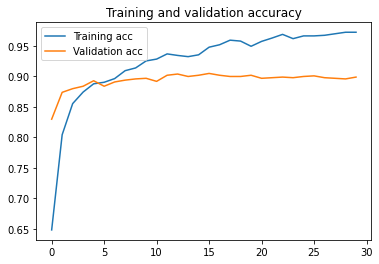

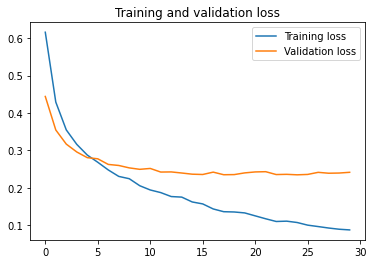

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

```

- 驗證準確率 - 到達到了 90% 

```

## 方法2: transfer learning

```
>> 方法 2 : - 卷積基底 : 凍結 + 串接新的密集分類層  - 重新訓練

    - 訓練過程中 - 利用數據擴充(Data Augmentation)
            - 擴展 conv_base 模型，並進行 (端 - End 對 端 - End) 的訓練
                        
                        
     - 模型 - 就像堆積木
             - 可以 添加一個模型(像 conv_base) 到　Sequential模型
             - 就像添加一個圖層一樣
     
     - 非常昂貴的
         - 每次輸入圖像每次被模型看到時都會經過 - 卷積基底 -
                        - 要花更多的計算與訓練時間
         - 建議 - 只有在你有GPU時才應該嘗試它
```      

```

>> 移花+接木

```

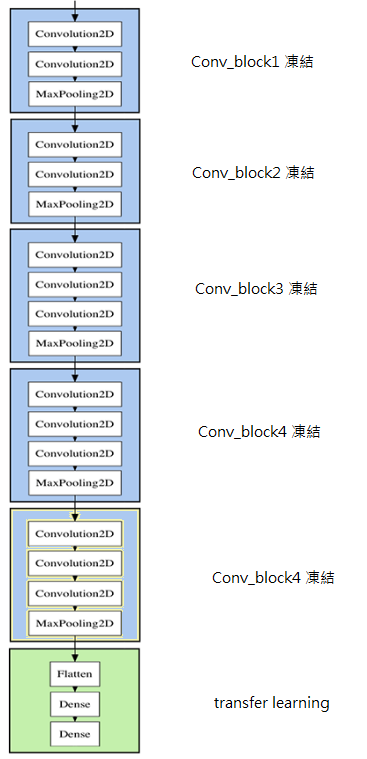

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()                       # 產生一個新的網絡模型結構
model.add(conv_base)                              # 把預訓練的卷積基底疊上去
model.add(layers.Flatten())                       # 打平
model.add(layers.Dense(256, activation='relu'))   # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(1, activation='sigmoid'))  # 因為資料集只有 - 兩類(Cat & Dog)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


```

- VGG16 的 - 卷積基底 - 
    -  14,714,688個參數，這非常大
    - 上面添加的分類器
        - 2097408 萬 - 參數 Parameters

    - 在編譯和訓練我們的模型之前
        - 一個非常重要的事情是凍結 - 卷積基底 -  
        
      >> 凍結 一層或多層圖層意味著在訓練期間防止其權重被更新
          - 如果不這樣做
          - 那麼以前在 - 卷積基底 - 上
          - 學到的特徵將在訓練期間被修改
          
          >> 由於頂層的 - Dense Layer - 層會被隨機初始化
              - 因此非常大的權重更新將通過網絡重新進行傳播
                  - 也會破壞以前學習的結果。

              - 在Keras中
                  - 通過 -trainable - 的屬性設置
                      - 為 - False 來凍結網絡
                      
```

In [ ]:
# 凍結前 - 卷積基底 有多少可以被訓練的權重

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [ ]:
# 凍結

conv_base.trainable = False

In [ ]:
# 凍結後 - 卷積基底 有多少可以被訓練的權重 

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


```

>> 通過這種設置，
    - 只有 添加的兩個 - Dense Layer 層的權重將被訓練
    
    - 這是總共有四個權重 的張量
        - 每層兩個 - 主要 - 權重矩陣 Wieghts
                         - 偏差向量 Bias
        
        - 必須首先編譯 Compile Model 模型

    - 數據增強配置
        - 數據擴充 ( Data Augmentation )

```

觀察資料與label之間的關係

第 0 批次樣本的 shape: (20, 150, 150, 3), 標籤的 shpae: (20,)


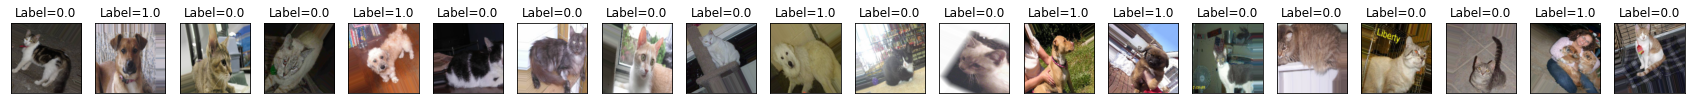

第 1 批次樣本的 shape: (20, 150, 150, 3), 標籤的 shpae: (20,)


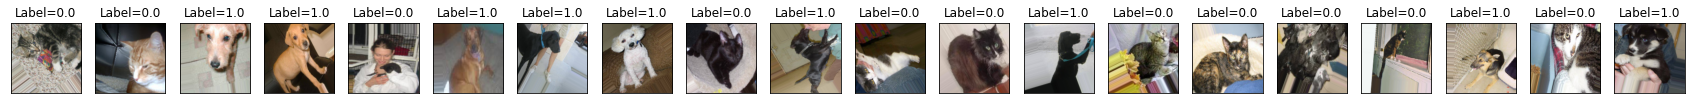

In [ ]:
num =0
for data , label in train_generator:
  print(f'第 {num} 批次樣本的 shape: {data.shape}, 標籤的 shpae: {label.shape}')
  plot_img(data, label)    #←呼叫自訂函式將樣本及標籤畫出來
  num += 1
  if num >=2:
    break

### 資料擴充(增強)
小幅度修改現有的樣本來產生更多的樣本，此方法在樣本數量不足時蠻有用的。
做法：例如將圖片(水平/垂直)反轉/稍做縮放/位移/旋轉等變化，
即可不斷產生新的相似圖片來訓練模型。
當不重複的樣本數量變多時，即可讓模型學到更多樣化的資料，
以減少過度擬合，並得到更好的普適性。

In [ ]:
%%time

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 驗證的資料 - 不要進行 資料的增強

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料 - 的目錄
        train_dir,
        # 設定圖像的 高( Height ) 與 寬( Width )
        target_size=(150, 150),
        batch_size=20,
        # 因為 - 目標資料集只有兩類(cat & dog)
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 57.4 ms, sys: 7.2 ms, total: 64.6 ms
Wall time: 208 ms


### 調整參數(訓練用):
```
>> 學習率eta: 
  ex: eta = 0.0001

  eta = 小數

>> 損失函數loss:

  ex: loss = 'binary_croossentropy'

  binary_crossentropy
  binary_crossentropy
  mse
  categorical_crossentropy

>> 優化器opt:
  ex: opt = optimizers.RMSprop(lr=eta)

  optimizers.SGD(lr=eta, momentum=0.9)
  optimizers.Adam(lr=eta, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

>> 迭代次數epoch:要訓練幾次
  ex: epoch = 10
  
```

In [ ]:
# parameter 
eta = 0.0001
loss = 'binary_crossentropy'   # binary_crossentropy / mse / categorical_crossentropy 
opt = optimizers.RMSprop(lr=eta) # optimizers.SGD(lr=eta, momentum=0.9) /optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
epoch = 10

編譯與訓練模型


In [ ]:
#model.compile(loss='binary_crossentropy',
#              optimizer=optimizers.RMSprop(lr=2e-5),
#              metrics=['acc'])
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 - 19s - loss: 0.5962 - acc: 0.6850 - val_loss: 0.4634 - val_acc: 0.8260
Epoch 2/30
100/100 - 18s - loss: 0.4823 - acc: 0.7965 - val_loss: 0.3755 - val_acc: 0.8690
Epoch 3/30
100/100 - 18s - loss: 0.4437 - acc: 0.8010 - val_loss: 0.3355 - val_acc: 0.8690
Epoch 4/30
100/100 - 18s - loss: 0.4068 - acc: 0.8205 - val_loss: 0.3245 - val_acc: 0.8650
Epoch 5/30
100/100 - 18s - loss: 0.3837 - acc: 0.8285 - val_loss: 0.2945 - val_acc: 0.8830
Epoch 6/30
100/100 - 18s - loss: 0.3615 - acc: 0.8465 - val_loss: 0.2871 - val_acc: 0.8850
Epoch 7/30
100/100 - 18s - loss: 0.3532 - acc: 0.8465 - val_loss: 0.2753 - val_acc: 0.8940
Epoch 8/30
100/100 - 18s - loss: 0.3555 - acc: 0.8405 - val_loss: 0.2714 - val_acc: 0.8880
Epoch 9/30
100/100 - 18s - loss: 0.3384 - acc: 0.8475 - val_loss: 0.2656 - val_acc: 0.8920
Epoch 10/30
100/100 - 18s - loss: 0.3295 - acc: 0.8660 - val_loss: 0.2630 - val_acc: 0.8900
Epoch 11/30
100/100 - 18s - loss: 0.3306 - acc: 0.8585 - val_loss: 0.2607 - val_acc: 0.89

In [ ]:
# 模型 儲存 Model Save 

model.save('cats_and_dogs_small_3.h5') 

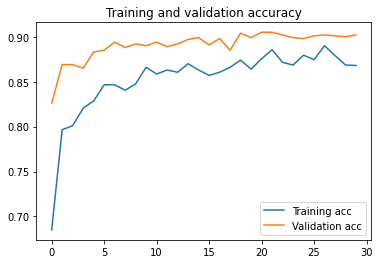

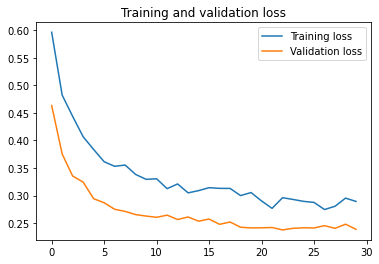

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

# 方法3:fine-tuning
```

>> 微調 (Fine-Tuning)
    - 模型重覆利用技術，與特徵提取( Feature Extraction ) 相輔相成
        - (微調) Fine-Tuning
        
    - 微調
        - 包括解凍用於特徵提取的凍結模型庫中的幾個頂層 (Top Layers)
        - 並且共同訓練新添加的模型部分 -
        
        - 範例中 - 是完全連接 FC 的分類器
            - 這些頂層 - 稱為 微調( Fine-Tuning)
        -     
```

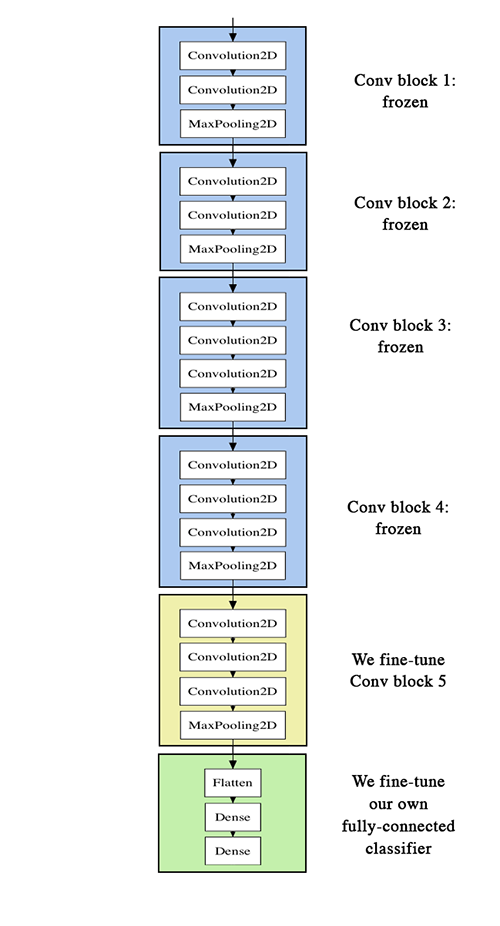

```

- 凍結 VGG16 - 卷積基底 - 
    - 在上面訓練一個隨機初始化的分類器
    - 一旦分類器已經被訓練，只能微調 - 卷積基底 -的頂層
    
- 如果分類尚未被訓練
    - 則在訓練期間通過網絡傳播的誤差信號將會變得太大
        - 並且被微調那些神經層先前學習的表示(Representation) - 將被破壞
        
- 微調網絡的步驟如下：

    - 1. 將自定義網絡添加到已經訓練好的基底網絡之上
    - 2. 凍結基底網絡
    - 3. 訓練您添加的部分
    - 4. 解凍基底網絡中的一些神經層
    - 5. 共同訓練這些層和您添加的部分

    - 在進行特徵提取時
        - 已經完成了 - 前3個步驟
        - 繼續第四步
            - 將解凍 - conv_base -
            - 然後凍結
                - 其中的某些特定的層

```

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

```

- 微調 (fine-tuning) 最後 3個 卷積層
    - 這意味著
    - 所有層直到 - block4_pool - 都應該被凍結
    - 而 block5_conv1 ， block5_conv2 和 block5_conv3 的層 - 是可訓練的

- 卷積基底 -中 
    - 較前面的神經層所學習到的特徵表示
    - 更加通用(generic)，更具有可重複使用的特徵
        - 而較高層次的特徵表示則聚焦獨特的特徵
    - 微調這些聚焦獨特的特徵的神經層則更為有用
        - 因為這些功能是需要重新被訓練來解決我們的新問題
    - 微調 愈底層 
        - 則從既有預訓練模型所得到的回報會愈少

- 訓練的 參數越多，越有可能的過擬合(overfitting)
        - VGG16 的 - 卷積基底 - 具有1千5百萬的參數
        - 小數據集上進行訓練 - 有風險

```

In [ ]:
conv_base.trainable = True # 解凍 "卷積基底"

# 所有層 - 直到 block4_pool - 都應該被凍結，而 block5_conv1，block5_conv2, block5_conv3 及 block5_pool- 被解凍 

layers_frozen = ['block5_conv1','block5_conv2', 'block5_conv3', 'block5_pool']
for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 每一層是否可以被 - trainable - 的 flat - 列印出來

for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable)) 

input_1: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


```

- 可以開始微調 - 網絡
    - 將使用非常低的學習率(Learning Rate) 使用 RMSprop 優化器
    - 使用低學習率的原因
        - 希望限制對進行微調的3個卷積層表示(Representation) - 所做的修改的大小幅度
        - 太大的更新
            - 可能會損害這些 - 表示(Representations)

```

In [ ]:
%%time
# 微調

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 小的 learning Rate
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 20s 187ms/step - loss: 0.2973 - acc: 0.8654 - val_loss: 0.2260 - val_acc: 0.9090
Epoch 2/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2608 - acc: 0.8897 - val_loss: 0.2091 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2239 - acc: 0.8997 - val_loss: 0.2170 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 19s 186ms/step - loss: 0.2145 - acc: 0.9122 - val_loss: 0.2134 - val_acc: 0.9190
Epoch 5/100
100/100 [==============================] - 19s 187ms/step - loss: 0.1912 - acc: 0.9207 - val_loss: 0.2078 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 19s 188ms/step - loss: 0.2143 - acc: 0.9173 - val_loss: 0.1874 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 19s 186ms/step - loss: 0.1775 - acc: 0.9268 - val_loss: 0.1890 - val_acc: 0.9240
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('cats_and_dogs_small_4.h5')

```

- 繪製結果

```

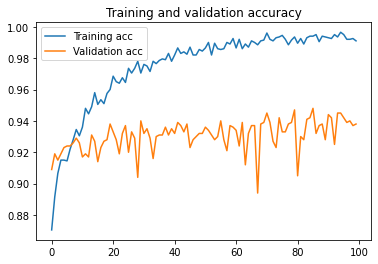

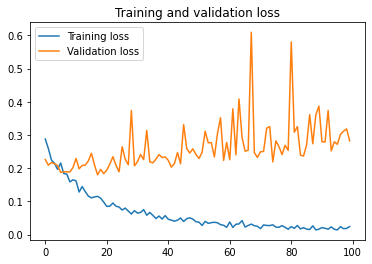

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

```

- 這些曲線看起來有很多的雜訊
    - 通過以這些數量的指數移動平均值代替
        - 每個損失和準確性來平滑它們
        
```

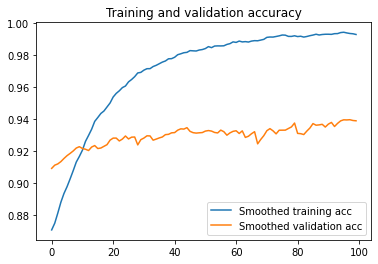

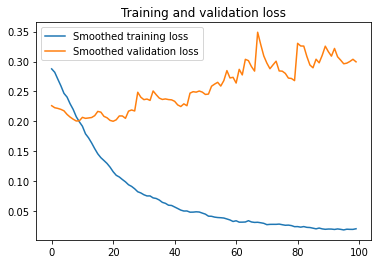

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 3.資料擴增
小幅度修改現有的樣本來產生更多的樣本，此方法在樣本數量不足時蠻有用的。  
做法：例如將圖片(水平/垂直)反轉/稍做縮放/位移/旋轉等變化，  
即可不斷產生新的相似圖片來訓練模型。  
當不重複的樣本數量變多時，即可讓模型學到更多樣化的資料，  
以減少過度擬合，並得到更好的普適性。

In [ ]:
!mkdir /content/aug/cat

In [ ]:
!cp /content/working/train/cat.10097.jpg /content/aug/cat

In [ ]:
a_dir = os.path.join('/content/aug/')
if not os.path.exists(a_dir): 
    os.mkdir(a_dir)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

gobj = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

a = gobj.flow_from_directory(
        # 圖像資料 - 的目錄
        a_dir,
        # 設定圖像的 高( Height ) 與 寬( Width )
        target_size=(150, 150),
        batch_size=1,
        # 因為 - 目標資料集只有兩類(cat & dog)
        classes=['cat'],
        class_mode=None)


Found 1 images belonging to 1 classes.


資料擴增範例

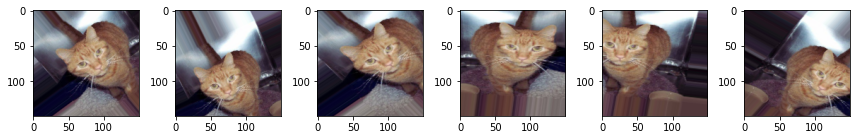

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    for X_batch,  in a:
        image = X_batch
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

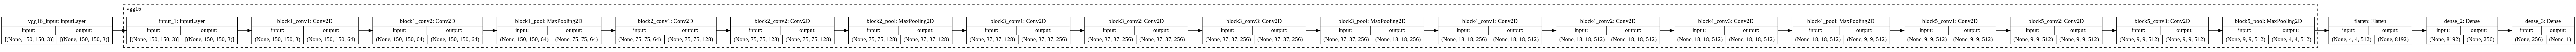

In [ ]:
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model_1.png')
#plot_model(model, to_file='model_2.png',show_shapes=True,show_layer_names=False)
#plot_model(model, to_file='model_3.png',rankdir='LR')
plot_model(model, to_file='model_3.png',rankdir='LR',show_shapes=True,expand_nested=True)

# 4.預測

In [ ]:
!mkdir /content/test/

In [ ]:
!mkdir /content/test/testing

In [ ]:
!cp /content/11.jpg /content/test/testing

In [ ]:
!cp /content/22.jpg /content/test/testing

In [ ]:
#tt_dir = os.path.join('/content/test/testing')
#if not os.path.exists(a_dir): 
#    os.mkdir(a_dir)
tt_dir = '/content/test/'

In [ ]:
tt_f_generator = test_datagen.flow_from_directory(
        tt_dir,
        target_size=(150, 150),
        batch_size=1,
        classes=['testing'],
        class_mode='binary')

Found 2 images belonging to 1 classes.


第 0 批次樣本的 shape: (1, 150, 150, 3)


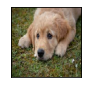

第 1 批次樣本的 shape: (1, 150, 150, 3)


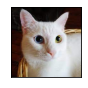

In [ ]:
num =0
for data , label in tt_f_generator:
  print(f'第 {num} 批次樣本的 shape: {data.shape}')
  plot_img(data)    
  num += 1
  if num >=2:
    break

In [ ]:
#predict = model.predict(test_set, steps=np.ceil(nb_samples/32))
#len(test_f_generator[0][0])
predict = model.predict(tt_f_generator)
predict = predict.reshape(-1)
predict[predict > 0.5] = 1
predict[predict < 0.5] = 0
print(predict.round(3))
#predict = model.predict_classes(tt_f_generator)
#print(predict.round(1))

[1. 0.]


In [ ]:
data1, _ = tt_f_generator[0]
pred_1 = predict[0]
plot_img(data1,pred_1)    